# NHANES Data analysis

This notebook shows how to load NHANES data (SAS XPORT .XPT or .CSV) into pandas, do quick sanity checks, and save a lightweight copy for faster reuse. It is designed to run either in Google Colab or in a Dev Container/VS Code environment.

## What you will need

- Data location (choose one):

  - Colab: MyDrive/fb3pfb_nhanes/data/raw/ (mounted as /content/drive/MyDrive/...)

- A file such as DEMO_G.XPT (Demographics) placed in the data/raw/ folder.

## How to use this notebook

- Point to your file: set DATA_FILE = "DEMO_G.XPT" (or the exact filename you uploaded).

- Run the cells: the loader auto-detects XPT vs CSV.

- Inspect quickly: head, column names, shape, and missingness summary.

- Save a tidy copy: the notebook writes a small feather/parquet file to data/processed/ for faster reloads.

## Typical workflow (suggested)

- Start with Demographics (DEMO) to get participant ID SEQN (lower-cased to seqn here).

- Load additional modules (e.g., dietary, examination, lab), merge by seqn.

- Keep exploratory work in /notebooks, move reusable code into /src/fb3pfb_nhanes/ as functions.

- Add small tests in /tests as your code solidifies.

## Notes on NHANES specifics

- Identifiers: SEQN is the unique participant key across files.

- Cycles: file suffixes (e.g., _G, _H) indicate survey cycles—ensure you are consistent when merging.

- Missingness: NHANES uses skip patterns; missing values are often structural (not errors).

- Weights: for estimates/inference you’ll need the appropriate sample weights (not applied here).

## Reproducibility & versioning

- Keep raw data read-only; write derived files to data/processed/.

- Record the cycle and file versions you used.


In [1]:
# --- FB3PFB / NHANES loader (Colab-friendly) ---------------------------------
# This cell mounts Google Drive, locates your project folder, lists available
# raw NHANES files, lets you pick one (optionally by a partial name), and loads
# it into a pandas DataFrame (supports .XPT [SAS XPORT] and .CSV).
# -----------------------------------------------------------------------------


# Standard library / third-party imports
from pathlib import Path            # Portable filesystem paths (better than string concatenation)
from google.colab import drive      # Colab-specific helper to mount Google Drive
import pandas as pd                 # Data handling library


# 1) Mount Drive (interactive in Colab)
# - This will prompt you to grant Colab access to your Google Drive.
# - `force_remount=True` allows remounting if it was mounted previously.
drive.mount('/content/drive', force_remount=True)


# 2) Detect your Drive base path
# - Colab typically mounts personal Drive at '/content/drive/MyDrive'.
# - On some accounts or older setups, it's '/content/drive/My Drive' (note the space).
# - If you keep the project in a Shared Drive, add that path to `candidates` below.
candidates = [
    Path('/content/drive/MyDrive'),
    Path('/content/drive/My Drive'),
]
# Example for a Shared Drive (uncomment and change the name):
# candidates.append(Path('/content/drive/Shareddrives/Your Shared Drive Name'))

# Pick the first candidate path that actually exists
base = next((p for p in candidates if p.exists()), None)
assert base, "Google Drive base folder not found. Is Drive mounted and is the path correct?"


# 3) Define project paths within Drive
# - We expect a folder structure like:
#     fb3pfb_nhanes/
#       data/
#         raw/         (place original NHANES files here, e.g. DEMO_G.XPT)
#         processed/   (outputs written here by later steps)
ROOT = base / 'fb3pfb_nhanes'
DATA_RAW = ROOT / 'data' / 'raw'
DATA_PROCESSED = ROOT / 'data' / 'processed'

# Ensure 'processed' exists so later saves don't fail
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# Guard: fail early if the expected raw folder is missing
assert DATA_RAW.exists(), f"Folder not found: {DATA_RAW}. Upload your NHANES file(s) there."


# 4) Show what is actually present in data/raw (useful when paths/filenames are wrong)
print("Files in data/raw:")
for p in sorted(DATA_RAW.iterdir()):
    print(" -", p.name)


# 5) Choose which file to load
# - Optionally set FIND to part of the filename (case-insensitive), e.g. "DEMO_G".
# - If FIND is empty, we simply pick the first .XPT or .CSV found.
FIND = ""   # e.g. "DEMO_G"  (leave empty to auto-pick the first readable file)

# Gather candidate files by extension (case-insensitive)
files = [
    *DATA_RAW.glob('*.xpt'), *DATA_RAW.glob('*.XPT'),
    *DATA_RAW.glob('*.csv'), *DATA_RAW.glob('*.CSV'),
]
assert files, "No .XPT or .CSV files found in data/raw. Upload at least one file."

if FIND:
    # Filter by partial name, ignoring case
    matches = [p for p in files if FIND.lower() in p.name.lower()]
    assert matches, f"No files matching '{FIND}' found in data/raw."
    raw_path = matches[0]  # take the first match
else:
    raw_path = files[0]    # take the first available file

print("Using file:", raw_path.name)


# 6) Load the file into pandas
# - NHANES distributes many tables as SAS XPORT (.XPT). pandas can read these via read_sas(format="xport").
# - CSV is read with read_csv as usual.
# - We standardise column names to lowercase to simplify merging later (SEQN -> seqn).
ext = raw_path.suffix.lower()

if ext == '.xpt':
    # read_sas returns a DataFrame; 'encoding' helps with any non-ASCII metadata
    df = pd.read_sas(raw_path, format='xport', encoding='utf-8')
elif ext == '.csv':
    # For large CSVs you can add options like dtype=..., usecols=..., or low_memory=False
    df = pd.read_csv(raw_path)
else:
    # Defensive programming: if we ever hit an unexpected extension, be explicit
    raise ValueError(f"Unsupported extension: {ext} (expected .xpt or .csv)")

# Normalise column names (lowercase) for consistency across modules/cycles
df.columns = [c.lower() for c in df.columns]




Mounted at /content/drive
Files in data/raw:
 - DEMO_J.xpt
Using file: DEMO_J.xpt


The dataset is now loaded. Let's have a look:

In [2]:

# Quick peek to verify it loaded as expected
print(df.shape)
df.head()

(9254, 46)


,seqn,sddsrvyr,ridstatr,riagendr,ridageyr,ridagemn,ridreth1,ridreth3,ridexmon,ridexagm,...,dmdhredz,dmdhrmaz,dmdhsedz,wtint2yr,wtmec2yr,sdmvpsu,sdmvstra,indhhin2,indfmin2,indfmpir
0,93703.0,10.0,2.0,2.0,2.0,NaN,5.0,6.0,2.0,27.0,...,3.0,1.0,3.0,9246.491865,8539.731348,2.0,145.0,15.0,15.0,5.00
1,93704.0,10.0,2.0,1.0,2.0,NaN,3.0,3.0,1.0,33.0,...,3.0,1.0,2.0,37338.768343,42566.614750,1.0,143.0,15.0,15.0,5.00
2,93705.0,10.0,2.0,2.0,66.0,NaN,4.0,4.0,2.0,NaN,...,1.0,2.0,NaN,8614.571172,8338.419786,2.0,145.0,3.0,3.0,0.82
3,93706.0,10.0,2.0,1.0,18.0,NaN,5.0,6.0,2.0,222.0,...,3.0,1.0,2.0,8548.632619,8723.439814,2.0,134.0,NaN,NaN,NaN
4,93707.0,10.0,2.0,1.0,13.0,NaN,5.0,7.0,2.0,158.0,...,2.0,1.0,3.0,6769.344567,7064.609730,1.0,138.0,10.0,10.0,1.88


Let's analyse some of the data

What data do we have?

df.info() gives an overview of the dataset. It shows data type and non-null observations.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9254 entries, 0 to 9253
Data columns (total 46 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   seqn      9254 non-null   float64
 1   sddsrvyr  9254 non-null   float64
 2   ridstatr  9254 non-null   float64
 3   riagendr  9254 non-null   object 
 4   ridageyr  9254 non-null   float64
 5   ridagemn  597 non-null    float64
 6   ridreth1  9254 non-null   float64
 7   ridreth3  9254 non-null   float64
 8   ridexmon  8704 non-null   float64
 9   ridexagm  3433 non-null   float64
 10  dmqmiliz  6004 non-null   float64
 11  dmqadfc   561 non-null    float64
 12  dmdborn4  9254 non-null   float64
 13  dmdcitzn  9251 non-null   float64
 14  dmdyrsus  1948 non-null   float64
 15  dmdeduc3  2306 non-null   float64
 16  dmdeduc2  5569 non-null   float64
 17  dmdmartl  5569 non-null   float64
 18  ridexprg  1110 non-null   float64
 19  sialang   9254 non-null   float64
 20  siaproxy  9254 non-null   floa

Now, we can compare age distribution

In [21]:
# ---- Continuous: Age ----
age_col = "ridageyr"   # Age in years - make it more legible

age = pd.to_numeric(df[age_col], errors="coerce") # Extract age for easier data handling

n_total = len(df[age_col])
n_nonmissing = df[age_col].notna().sum()
n_missing = n_total - n_nonmissing

mean = df[age_col].mean()
sd   = df[age_col].std(ddof=1)
median = df[age_col].median()
q25 = df[age_col].quantile(0.25)
q75 = df[age_col].quantile(0.75)

print(f"Age (years): n={n_nonmissing}/{n_total}; missing={n_missing}")
print(f"  Mean ± SD:    {mean:.1f} ± {sd:.1f}")
print(f"  Median [IQR]: {median:.1f} [{q25:.1f}, {q75:.1f}]")

Age (years): n=9254/9254; missing=0
  Mean ± SD:    34.3 ± 25.5
  Median [IQR]: 31.0 [11.0, 58.0]


Now, let's investigate whether there's a sex-difference. Let's start in a simple way:

In [26]:
age_mean_by_sex = df.groupby("riagendr")["ridageyr"].mean()
age_sd_by_sex = df.groupby("riagendr")["ridageyr"].std(ddof=1)
age_median_by_sex = df.groupby("riagendr")["ridageyr"].median()
age_q25_by_sex = df.groupby("riagendr")["ridageyr"].quantile(0.25)
age_q75_by_sex = df.groupby("riagendr")["ridageyr"].quantile(0.75)

print(age_mean_by_sex.round(1).to_frame(name="mean_age"))
print(age_median_by_sex.round(1).to_frame(name="median_age"))



          mean_age
riagendr          
Female        34.5
Male          34.1
          median_age
riagendr            
Female          32.0
Male            30.0


Let's compare age between the sexes using a t-test:

In [27]:
from scipy import stats     # Library for statistical tests



# Extract groups (drop missing ages)
age_f = df.loc[df["riagendr"] == "Female", age_col].dropna()
age_m = df.loc[df["riagendr"] == "Male",   age_col].dropna()

# Welch's t-test (does not assume equal variances)
t_stat, p_val = stats.ttest_ind(age_f, age_m, equal_var=False, nan_policy="omit")

print(f"Welch's t-test (Female vs Male)")
print(f"  n_female = {len(age_f)}, n_male = {len(age_m)}")
print(f"  t = {t_stat:.3f}, p = {p_val:.3g}")



Welch's t-test (Female vs Male)
  n_female = 4697, n_male = 4557
  t = 0.809, p = 0.419


And now a density plot

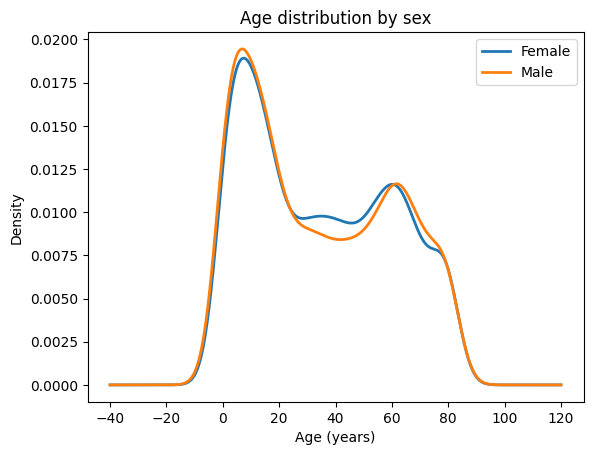

In [28]:
import matplotlib.pyplot as plt

s_f = df.loc[df[sex_col] == "Female", age_col].dropna()
s_m = df.loc[df[sex_col] == "Male",   age_col].dropna()

plt.figure()
s_f.plot(kind="kde", linewidth=2, label="Female")
s_m.plot(kind="kde", linewidth=2, label="Male")
plt.xlabel("Age (years)")
plt.ylabel("Density")
plt.title("Age distribution by sex")
plt.legend()
plt.show()
